In [1]:
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 13.2 MB/s eta 0:00:00


In [2]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7782d9caac067664e15777b5191ec1287d8e9c8941441c96f8e0279fef725a15
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [3]:
import os
import random
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from efficientnet_pytorch import EfficientNet


In [4]:
import sys
import wandb
sys.path.append('/kaggle/usr/lib/wandblogin/')
from wandblogin import login
login()

# # Initialize wandb
wandb.init(project="fracatlas-fracture-detection")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shyamdgupta (shyam-d-gupta). Use `wandb login --relogin` to force relogin


In [5]:
coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')
img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
image_id = 12

img = coco.imgs[image_id]


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()


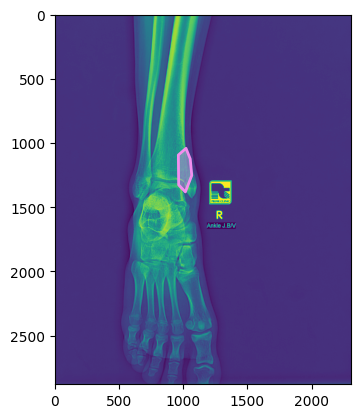

In [7]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

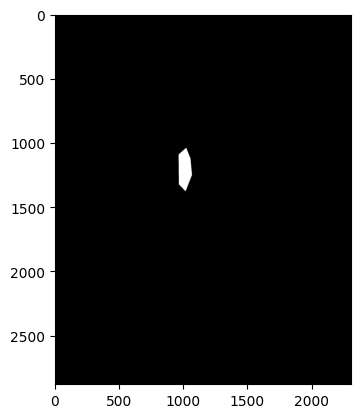

In [8]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask,cmap='gray')

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


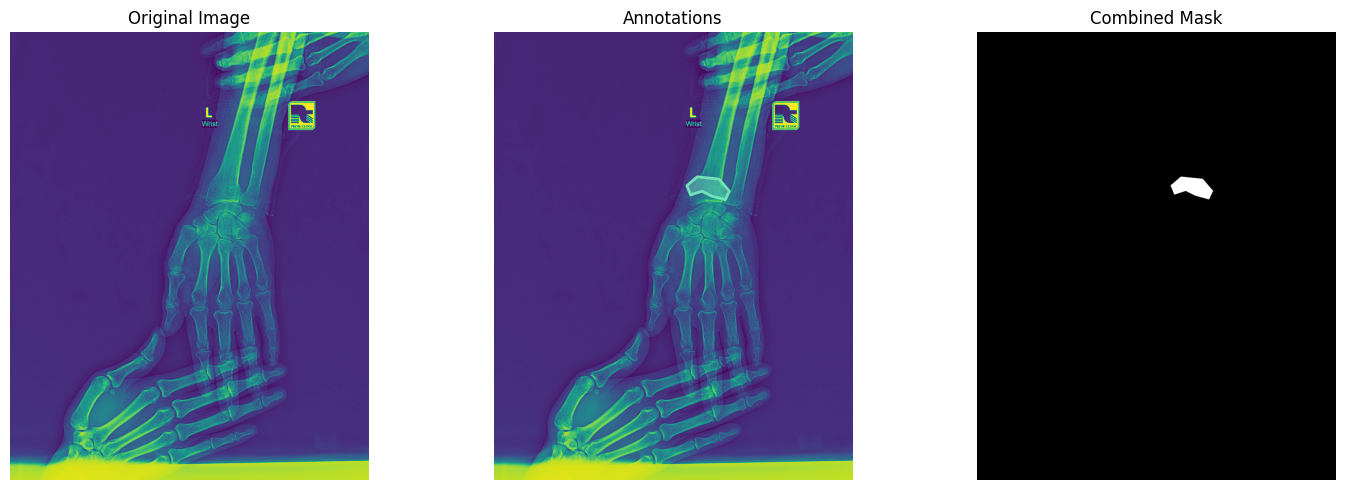

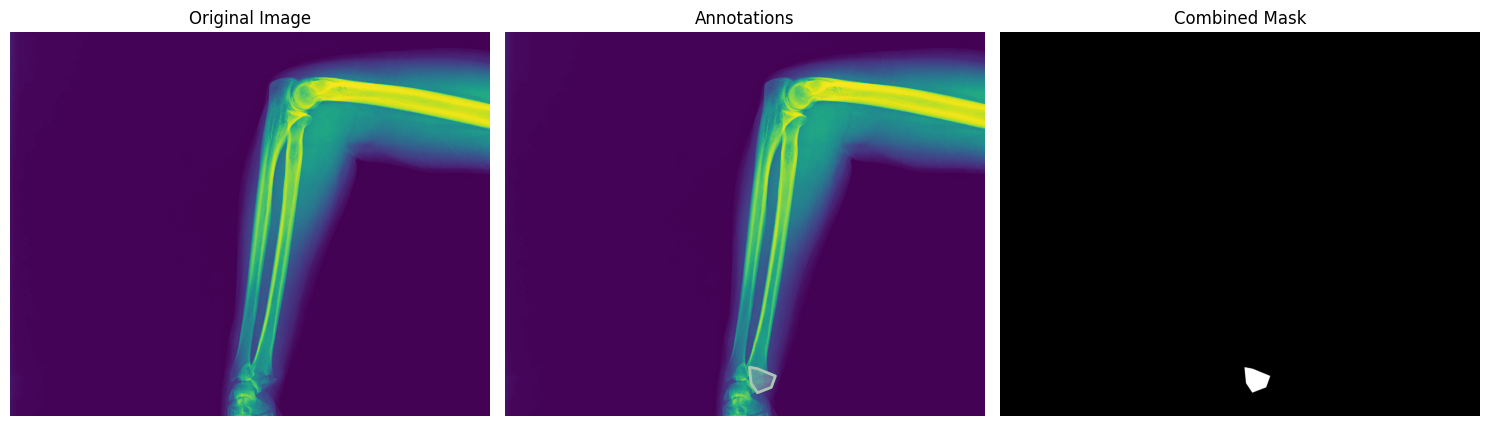

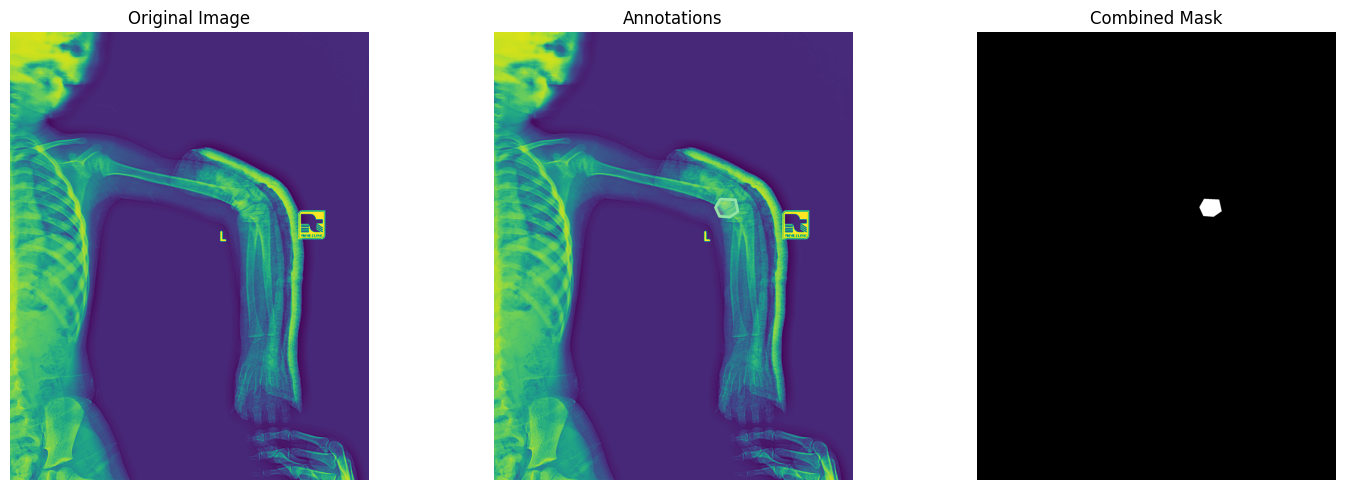

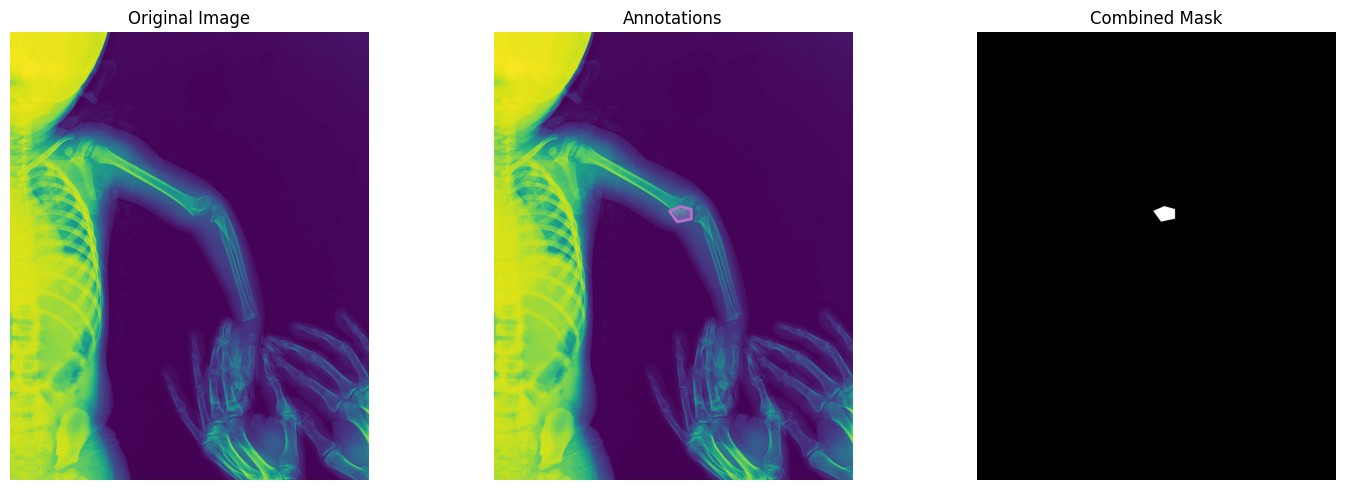

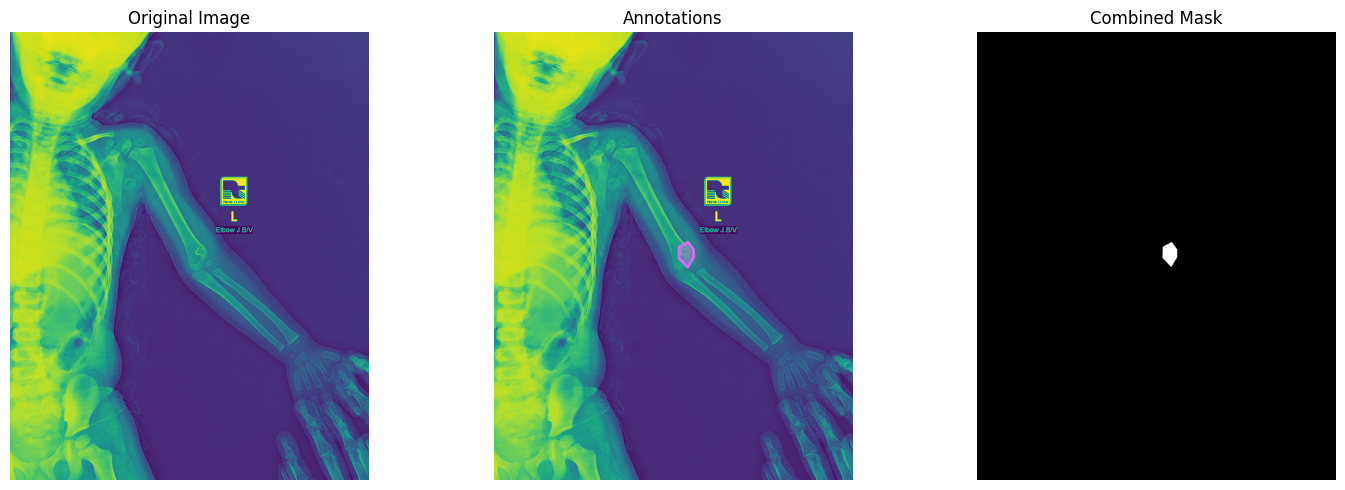

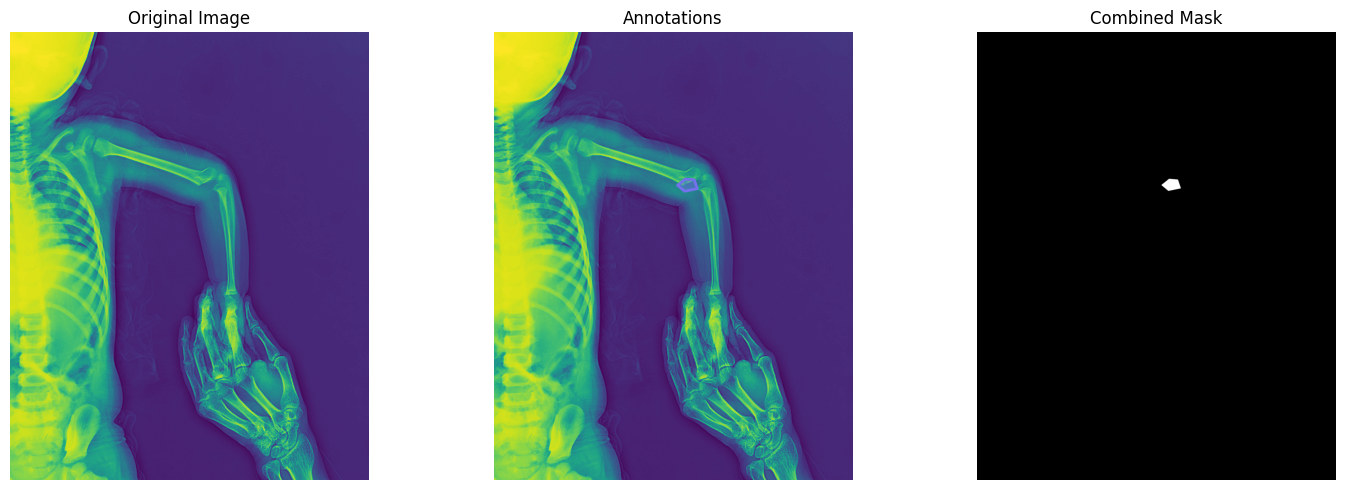

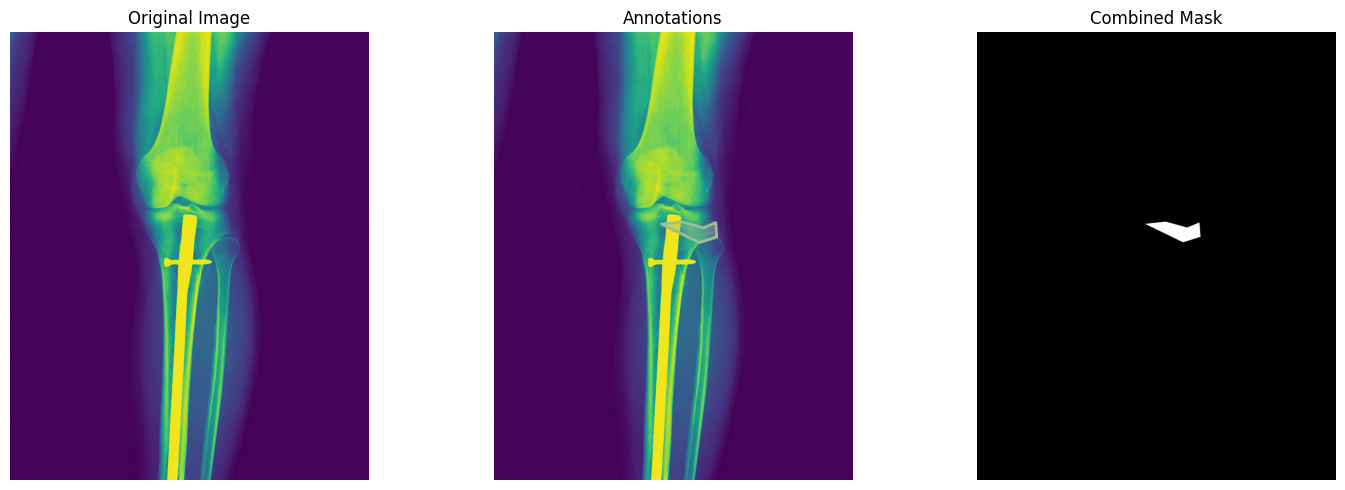

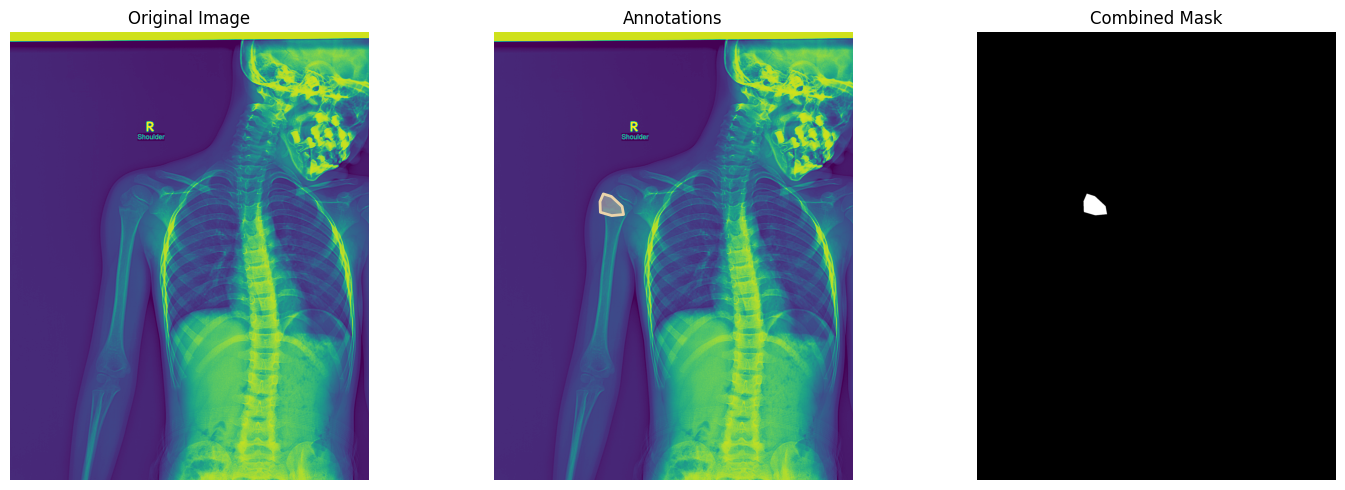

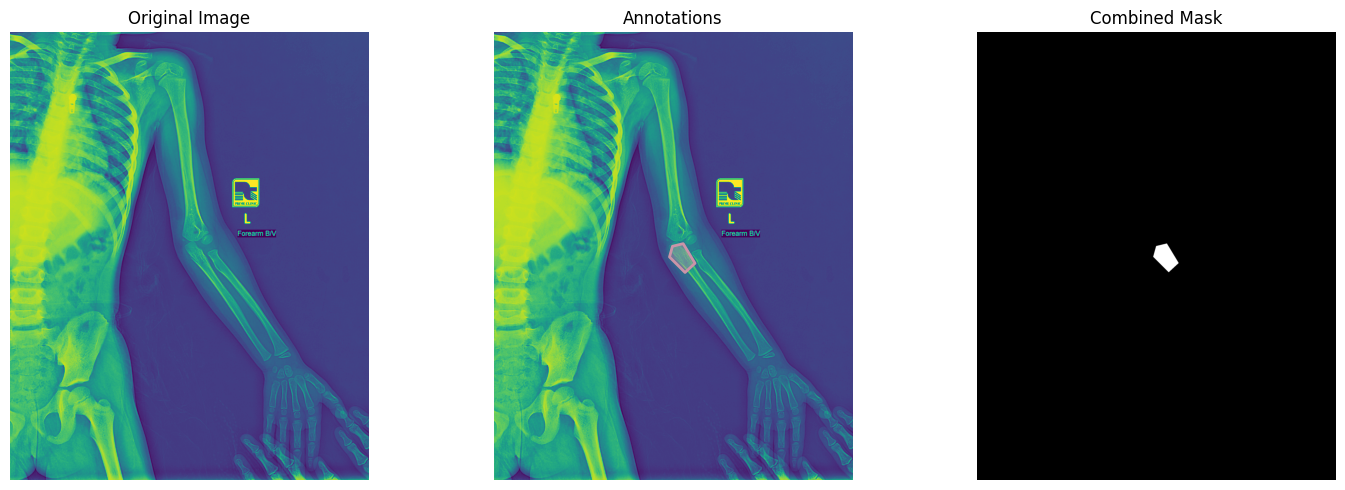

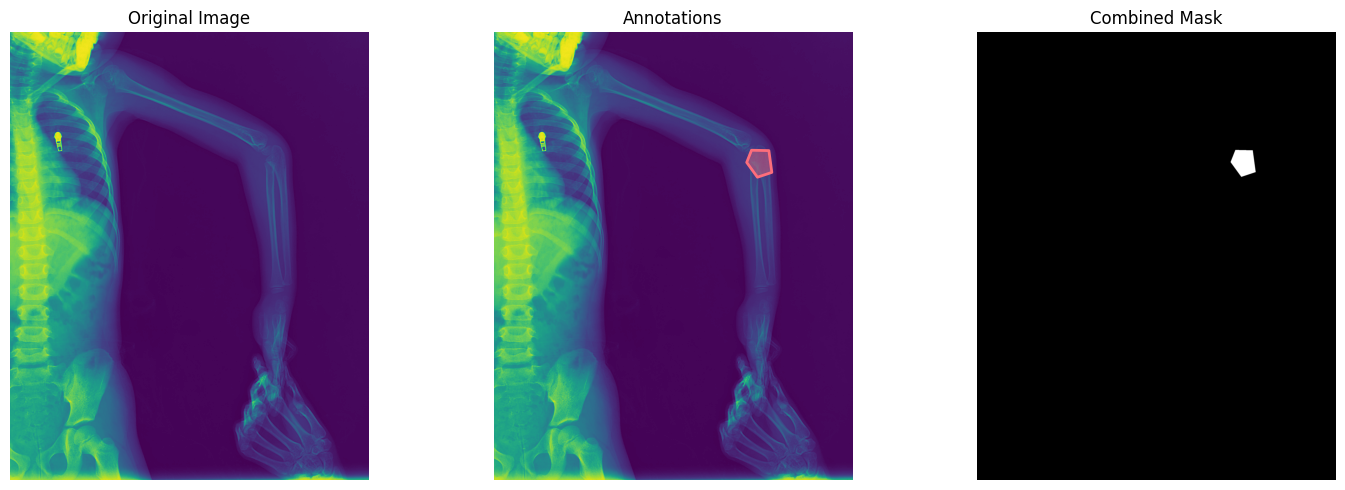

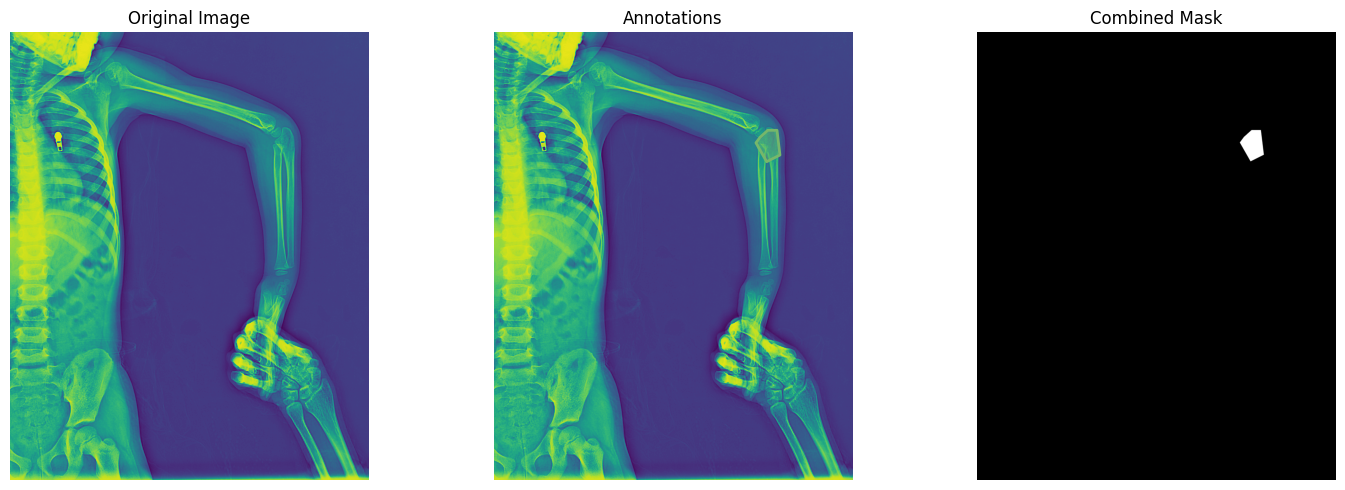

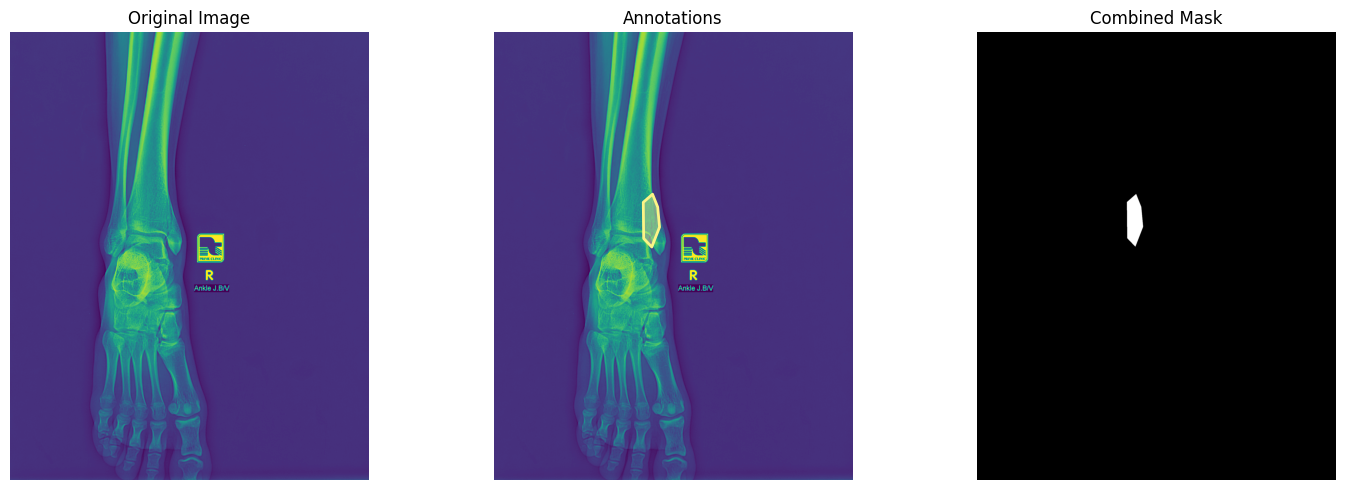

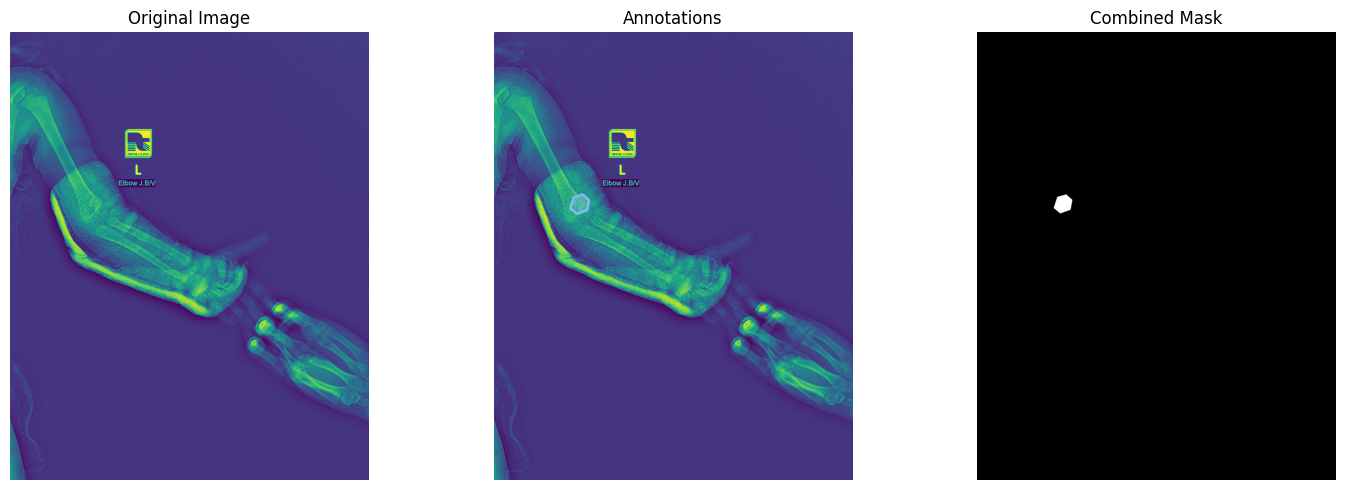

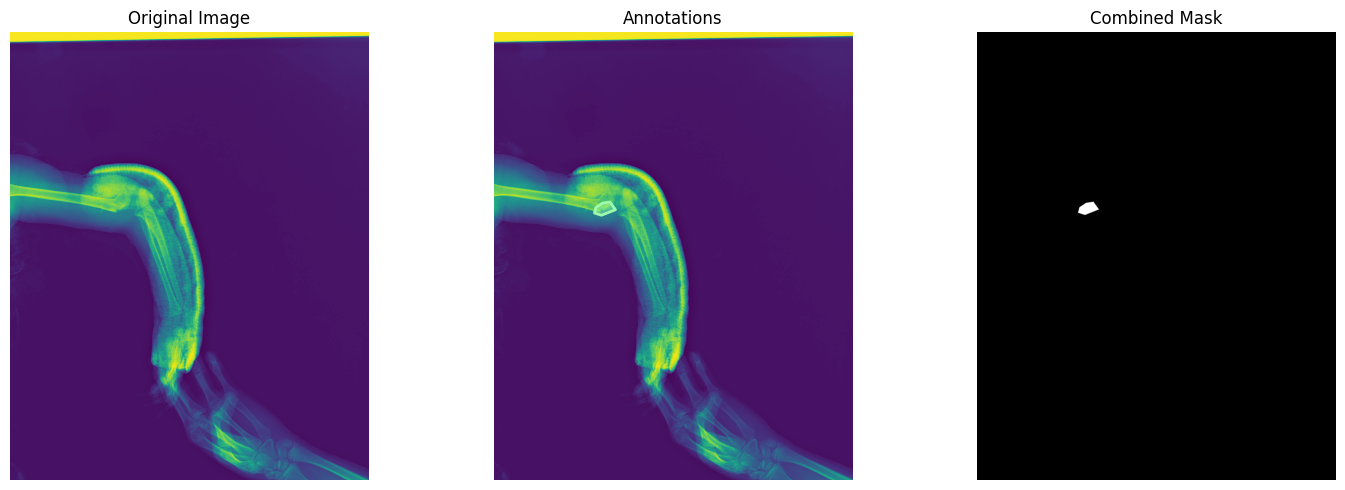

In [9]:

coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')

img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
output_dir = '/kaggle/working/fracatlas/images/fractured_masks/'

os.makedirs(output_dir, exist_ok=True)

image_ids = coco.getImgIds()
num_images =14
for i in range(num_images):    
    img = coco.loadImgs(image_ids[i])[0]
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))

    

    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = coco.annToMask(anns[0])
    for j in range(1, len(anns)):
        mask += coco.annToMask(anns[j])
        
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title('Annotations')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')
    
    plt.tight_layout()
    plt.show()


In [36]:



image_folder_fractured = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
image_folder_non_fractured = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Non_fractured'
train_folder = '/kaggle/working/train'
val_folder = '/kaggle/working/val'
test_folder = '/kaggle/working/test'

os.makedirs(train_folder + '/fractured', exist_ok=True)
os.makedirs(train_folder + '/non_fractured', exist_ok=True)
os.makedirs(val_folder + '/fractured', exist_ok=True)
os.makedirs(val_folder + '/non_fractured', exist_ok=True)
os.makedirs(test_folder + '/fractured', exist_ok=True)
os.makedirs(test_folder + '/non_fractured', exist_ok=True)

def split_images(image_folder, train_folder, val_folder, test_folder, split_ratio=(0.8, 0.1, 0.1)):
    image_files = os.listdir(image_folder)
    random.shuffle(image_files)
    num_images = len(image_files)
    num_train = int(split_ratio[0] * num_images)
    num_val = int(split_ratio[1] * num_images)

    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train + num_val]
    test_files = image_files[num_train + num_val:]

    for file in train_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(train_folder, file))
    for file in val_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(val_folder, file))
    for file in test_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(test_folder, file))

split_images(image_folder_fractured, train_folder + '/fractured', val_folder + '/fractured', test_folder + '/fractured')
split_images(image_folder_non_fractured, train_folder + '/non_fractured', val_folder + '/non_fractured', test_folder + '/non_fractured')

transform = transforms.Compose([
    transforms.Resize((224,224)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(val_folder, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [37]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [38]:

model = EfficientNet.from_pretrained('efficientnet-b6')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


Loaded pretrained weights for efficientnet-b6


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        56, 14, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        14, 56, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [39]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_acc = 0.0

# Log initial configuration
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 150
}

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    torch.cuda.empty_cache()
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'), 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Log training metrics
    wandb.log({"epoch": epoch+1, "train_loss": running_loss/len(train_loader)})

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Log validation images
            if i == 0:
                wandb.log({"examples": [wandb.Image(img) for img in images.cpu()]})

    val_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc*100:.2f}%')

    # Log validation accuracy
    wandb.log({"val_accuracy": val_acc})

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print("saving...")
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

print('Finished Training')

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Log final test accuracy
wandb.log({"test_accuracy": test_accuracy})


Epoch 1/20: 100%|██████████| 256/256 [02:20<00:00,  1.82it/s]


Epoch 1/20, Loss: 0.3986, Validation Accuracy: 79.18%
saving...


Epoch 2/20: 100%|██████████| 256/256 [02:20<00:00,  1.82it/s]


Epoch 2/20, Loss: 0.3253, Validation Accuracy: 83.96%
saving...


Epoch 3/20: 100%|██████████| 256/256 [02:20<00:00,  1.82it/s]


Epoch 3/20, Loss: 0.2840, Validation Accuracy: 90.74%
saving...


Epoch 4/20: 100%|██████████| 256/256 [02:20<00:00,  1.82it/s]


Epoch 4/20, Loss: 0.2258, Validation Accuracy: 93.16%
saving...


Epoch 5/20: 100%|██████████| 256/256 [02:21<00:00,  1.80it/s]


Epoch 5/20, Loss: 0.1855, Validation Accuracy: 97.09%
saving...


Epoch 6/20: 100%|██████████| 256/256 [02:20<00:00,  1.82it/s]


Epoch 6/20, Loss: 0.1910, Validation Accuracy: 93.34%


Epoch 7/20: 100%|██████████| 256/256 [02:21<00:00,  1.81it/s]


Epoch 7/20, Loss: 0.1329, Validation Accuracy: 97.40%
saving...


Epoch 8/20: 100%|██████████| 256/256 [02:21<00:00,  1.80it/s]


Epoch 8/20, Loss: 0.0994, Validation Accuracy: 96.31%


Epoch 9/20: 100%|██████████| 256/256 [02:22<00:00,  1.80it/s]


Epoch 9/20, Loss: 0.0836, Validation Accuracy: 97.15%


Epoch 10/20:  42%|████▏     | 107/256 [00:59<01:22,  1.81it/s]


KeyboardInterrupt: 

In [40]:

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Log final test accuracy
wandb.log({"test_accuracy": test_accuracy})


Test Accuracy: 96.83%
